# Imports

In [ ]:
from pathlib import Path
from datetime import datetime
import torch
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import uncertainty_toolbox as uct
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from simple_uq.models.pnn import PNN

# Uploads

In [66]:
uploaded = {p.name: p for p in Path("./data/earth").glob("*.xlsx") if not p.name.startswith("~$")}
uploaded_1A = {p.name: p for p in Path("./data/flight").glob("*.xlsx") if not p.name.startswith("~$")}

# Settings

In [67]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [68]:
plt.rcParams.update({
    'axes.labelsize': 14,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'xtick.color': 'k',
    'ytick.color': 'k',
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
})
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['figure.dpi'] = 120

# Preprocessing

In [69]:
organism_list = []
substance_list = []
gravity_list = []
obj_list = []

class Preprocess:
  def __init__(self, file_name):
    self.file_name = file_name
    self.organism, self.substance, self.gravity = self.file_name.split(".")[0].split()[0].split("_")
    self.update_list(organism_list, self.organism)
    self.update_list(substance_list, self.substance)
    self.update_list(gravity_list, self.gravity)

  def update_list(self, item_list, item):
    #if item not in item_list:
    item_list.append(item)

In [70]:
for file_name in uploaded.keys():
  obj = Preprocess(file_name)
  obj_list.append(obj)

In [71]:
organism_encode = LabelEncoder()
substance_encode = LabelEncoder()
gravity_encode = LabelEncoder()

organism_label = organism_encode.fit_transform(organism_list)
substance_label = substance_encode.fit_transform(substance_list)
gravity_label = gravity_encode.fit_transform(gravity_list)

In [72]:
data_list = []
prefix = "./data/earth"
prefix_1A = "./data/flight"
class Data:
  def __init__(self,file_name, organism, substance, gravity, flight = False):
    self.file_name = file_name
    self.organism = organism
    self.substance = substance
    self.gravity = gravity
    self.flight = flight
    self.growth_time, self.growth_val = self.assign_data()
    self.growth_input_np = self.create_inputs(self.growth_time, self.growth_val)
    self.growth_val_np = self.growth_val.reshape(-1, 1)

  def assign_data(self):
    if self.flight:
      growth_df = pd.read_excel(f"{prefix_1A}/{self.file_name}", sheet_name = 0).iloc[1:]
    else:
      growth_df = pd.read_excel(f"{prefix}/{self.file_name}", sheet_name = 0).iloc[1:]
    growth_time = growth_df.iloc[:,:1].to_numpy()
    growth_df_transpose = growth_df.iloc[:,1:].T
    growth_df_transpose.fillna(growth_df_transpose.mean(), inplace = True)
    growth_val = growth_df_transpose.T.to_numpy()

    return growth_time, growth_val

  def create_inputs(self, input, output):
    """
    Returns inputs in order of organism, substance, gravity, and time
    """
    input_length = len(input)
    output_length = len(output[0])

    input_stacked = np.tile(input, output_length).reshape(-1, 1)

    categorical_inputs = [self.organism, self.substance, self.gravity]
    categorical_inputs_stacked = np.tile(categorical_inputs, input_length * output_length).reshape(-1, len(categorical_inputs))

    return np.hstack((categorical_inputs_stacked, input_stacked)).astype(float)

In [ ]:
for i, obj in enumerate(obj_list):
  data_obj = Data(obj.file_name, organism_label[i], substance_label[i], gravity_label[i])
  data_list.append(data_obj)

In [74]:
growth_input = data_list[0].growth_input_np
growth_output = data_list[0].growth_val_np

for i in range(1, len(data_list)):
  growth_input = np.vstack((growth_input, data_list[i].growth_input_np))
  growth_output = np.vstack((growth_output, data_list[i].growth_val_np))

In [75]:
growth_time_input_mean = np.mean(growth_input[:, 3])
growth_time_input_std_dev = np.std(growth_input[:, 3])
growth_input[:,3] = (growth_input[:, 3] - growth_time_input_mean)/growth_time_input_std_dev

In [76]:
#80% train, 10% validation, 10% test
growth_input_train, growth_input_test_val, growth_output_train, growth_output_test_val = train_test_split(growth_input, growth_output, test_size = 0.2, random_state = 42)
growth_input_val, growth_input_test, growth_output_val, growth_output_test = train_test_split(growth_input_test_val, growth_output_test_val, test_size = 0.5, random_state = 42)

In [77]:
growth_input_train_tensor = torch.tensor(growth_input_train, device=device)
growth_input_test_tensor = torch.tensor(growth_input_test,device=device)
growth_output_train_tensor = torch.tensor(growth_output_train,device=device)
growth_output_test_tensor = torch.tensor(growth_output_test,device=device)
growth_input_val_tensor = torch.tensor(growth_input_val, device=device)
growth_output_val_tensor = torch.tensor(growth_output_val, device=device)

In [78]:
train_data = DataLoader(TensorDataset(torch.tensor(growth_input_train, dtype = torch.float32), torch.tensor(growth_output_train, dtype = torch.float32)))
test_data = DataLoader(TensorDataset(torch.tensor(growth_input_test, dtype = torch.float32), torch.tensor(growth_output_test, dtype = torch.float32)))
val_data = DataLoader(TensorDataset(torch.tensor(growth_input_val, dtype = torch.float32), torch.tensor(growth_output_val, dtype = torch.float32)))

# Model

In [79]:
"""Make the PNN model."""
pnn = PNN(
    input_dim=4,
    output_dim=1,
    encoder_hidden_sizes=[50, 50, 50, 50, 50],
    encoder_output_dim=50,
    mean_hidden_sizes=[],
    logvar_hidden_sizes=[],
    hidden_activation = F.relu,
    learning_rate = 1e-3,
)

In [80]:
model_path = './models/growth'
if not model_path:
  """Train the model with a pytorch-lightning trainer."""
  trainer = pl.Trainer(max_epochs=100, check_val_every_n_epoch=50)
  trainer.fit(pnn, train_data, val_data)
  # Get the test output.
  test_results = trainer.test(pnn, test_data)
  #model_path = '/content/drive'
  timestamp = datetime.now()
  time_path = f"_{timestamp.strftime('%m-%d_%H-%M-%S')}.pth"
  torch.save(pnn.state_dict(), model_path + time_path)
else:
  #load the model
  time_path = ".pth"
  pnn.load_state_dict(torch.load(model_path + time_path))

# Flight

In [81]:
organism_1A_list = []
substance_1A_list = []
gravity_1A_list = []
obj_1A_list = []

In [82]:
class Preprocess_flight:
  def __init__(self, file_name):
    self.file_name = file_name
    self.organism, self.substance, self.gravity, self.flight = self.file_name.split(".")[0].split()[0].split("_")
    self.update_list(organism_1A_list, self.organism)
    self.update_list(substance_1A_list, self.substance)
    self.update_list(gravity_1A_list, self.gravity)

  def update_list(self, item_list, item):
    #if item not in item_list:
    item_list.append(item)

In [83]:
for file_name in uploaded_1A.keys():
  obj = Preprocess_flight(file_name)
  obj_1A_list.append(obj)

In [84]:
def locate_label(var, var_list, var_encode_list):
  index = var_list.index(var)
  return var_encode_list[index]

C:\Users\ipjos\AppData\Local\Temp\ipykernel_10704\1938128695.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  growth_df_transpose.fillna(growth_df_transpose.mean(), inplace = True)


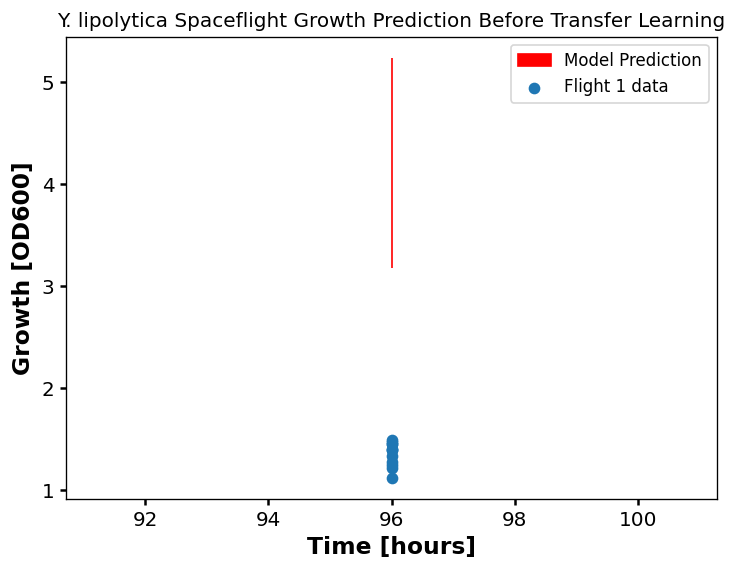

In [87]:
data_1A_list = []

for i, obj in enumerate(obj_1A_list):
  organism_locate_label = locate_label(obj.organism, organism_list, organism_label)
  substance_locate_label = locate_label(obj.substance, substance_list, substance_label)
  gravity_locate_label = locate_label(obj.gravity, gravity_list, gravity_label)

  #use the combination of labels to locate the correct obj_list item
  data_obj = Data(obj.file_name, organism_locate_label, substance_locate_label, gravity_locate_label, flight = True)
  data_1A_list.append(data_obj)

  #combine into categorical inputs
  categorical_inputs = [organism_locate_label, substance_locate_label, gravity_locate_label]
  categorical_inputs_transformed = torch.tensor([categorical_inputs]).squeeze()

  #replace time_linspace_tensor, define this as the list of time elements
  time_tensor = torch.tensor(data_obj.growth_input_np[:,3], dtype = torch.float32)
  categorical_inputs_transformed_stacked = torch.Tensor.repeat(categorical_inputs_transformed, len(time_tensor)).reshape(-1, len(categorical_inputs))

  input_unstandardized = torch.hstack((categorical_inputs_transformed_stacked, time_tensor.reshape(-1, 1)))
  input_unstandardized[:,3] = (input_unstandardized[:,3] - growth_time_input_mean) / growth_time_input_std_dev

  input_standardized = input_unstandardized
  predicted_output_mean, predicted_output_std = pnn.get_mean_and_standard_deviation(input_standardized.numpy())
  time_tensor = time_tensor.numpy().flatten()
  predicted_output_mean = predicted_output_mean.flatten()
  predicted_output_std = predicted_output_std.flatten()

  # plt.title(f"{organism_encode.inverse_transform([data_obj.organism])[0]} {substance_encode.inverse_transform([data_obj.substance])[0]} {gravity_encode.inverse_transform([data_obj.gravity])[0]} Growth with 95% Confidence Interval")

  plt.title("Y. lipolytica Spaceflight Growth Prediction Before Transfer Learning")

  plt.fill_between(
    time_tensor,
    predicted_output_mean - 3 * predicted_output_std,
    predicted_output_mean + 3 * predicted_output_std,
    color = 'red',
    # label=f"{gravity_encode.inverse_transform([data_1A_list[i].gravity])[0]} Prediction"
    label = "Model Prediction"
  )

  plt.scatter(
    time_tensor,
    data_obj.growth_val_np,
    label = "Flight 1 data"
  )

  plt.xlabel("Time [hours]")
  plt.ylabel("Growth [OD600]")
  plt.legend()
  plt.show()